<a href="https://colab.research.google.com/github/ssosoo/2024_DS60/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D/Word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


# 항상 같은 결과를 갖기 위해 랜덤 시드 설정
tf.random.set_seed(1)
np.random.seed(1)

In [31]:
corpus = ['king is a strong man',
          'queen is a wise woman',
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong',
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

In [32]:
# 불용어 제거
def remove_stop_words(corpus):
  stop_words = ['is', 'a', 'will', 'be']
  results = []

  for text in corpus:
    tmp = text.split(' ')
    for stop_word in stop_words:
      if stop_word in tmp:
        tmp.remove(stop_word)
    results.append(" ".join(tmp))
  return results

corpus = remove_stop_words(corpus)


In [33]:
for text in corpus:
  print(text)

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [34]:
words = []
for text in corpus:
  for word in text.split(' '):
    words.append(word)

words = set(words)

words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

단어를 원 핫 인코딩으로 변환하기 위해 인덱스로 인코딩한다.
**key-단어***

***값-index***

In [35]:
word2int = {}
for i, word in enumerate(words):
  word2int[word] = i

In [36]:
word2int

{'woman': 0,
 'man': 1,
 'queen': 2,
 'wise': 3,
 'strong': 4,
 'prince': 5,
 'pretty': 6,
 'young': 7,
 'princess': 8,
 'girl': 9,
 'boy': 10,
 'king': 11}

**레이블 생성**

스킵 그램 방식으로 각 단어별 레이블을 생성한다.

In [37]:
sentences = []
for sentence in corpus:
  sentences.append(sentence.split())


WINDOW_SIZE = 2

data = []

for sentence in sentences :
  for idx, word in enumerate(sentence):
    for neighbor in sentence[ \
        #문장 시작부분에서 인덱스가 음수가 되는 것을 방지
        max(idx - WINDOW_SIZE, 0) : \
        #문장 끝에서 인덱스가 범위를 넘어가는 것을 방지
        min(idx + WINDOW_SIZE, len(sentence)) + 1] :
      if neighbor != word:
        data.append([word, neighbor])

In [38]:
df = pd.DataFrame(data, columns = ['input', 'label'])
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


**모델 구현**

In [39]:
ONE_HOT_DIM = len(words)

# 숫자를 원 핫 인코딩으로 전환
def to_one_hot_encoding(data_point_index):
  one_hot_encoding = np.zeros(ONE_HOT_DIM)
  one_hot_encoding[data_point_index] = 1
  return one_hot_encoding

# X는 입력 단어, Y는 레이블
X = []
Y = []

# zip()는 두개의 리스트를 동시 순회한다.
# x,y는 각각의 리스트를 순회한다. word2int는 단어를 받아 숫자로 변환해준다.
# 최종적으로 X, Y에는 [0100000 ...] 형태의 숫자로 정보가 저장된다.
for x, y in zip(df['input'], df['label']):
  X.append(to_one_hot_encoding(word2int[x]))
  Y.append(to_one_hot_encoding(word2int[y]))

# 학습 데이터를 지정합니다.
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# 시각화를 위해 2차원으로 인코딩합니다.
encoding_dim = 2
# 입력값은 원 핫 인코딩입니다. 단어의 개수만큼 차원을 가진 벡터입니다.
input_word = Input(shape=(ONE_HOT_DIM,))
# 가중치를 그대로 word2vec로 사용하기 위해 편향값을 주지 않습니다.
encoded = Dense(encoding_dim, use_bias = False)(input_word)
# 디코더는 전달된 값을 원 핫 인코딩으로 전환합니다.
decoded = Dense(ONE_HOT_DIM, activation = 'softmax')(encoded)

# word2vec 모델을 지정합니다.
w2v_model = Model(input_word, decoded)

# 손실함수: 크로스 엔트로피, 최적화: 아담 옵티마이저 사용
w2v_model.compile(optimizer='adam', loss='categorical_crossentropy')

In [40]:
# 학습을 진행합니다.
w2v_model.fit(X_train, Y_train, epochs=1000, shuffle=True, verbose=0)

In [41]:
# word2vec 추출
vectors = w2v_model.layers[1].weights[0].numpy().tolist()

In [42]:
#word2vec 좌푯값

w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = list(words)
w2v_df = w2v_df[['word','x1', 'x2']]
w2v_df

,word,x1,x2
0,woman,1.874529,1.692563
1,man,-1.647027,1.140318
2,queen,1.643192,0.220591
3,wise,1.713432,-0.708496
4,strong,-0.949385,-1.544589
5,prince,-0.813689,0.389873
6,pretty,1.411681,-1.303338
7,young,0.031773,-0.766231
8,princess,1.384961,0.830800
9,girl,1.373142,-0.129256


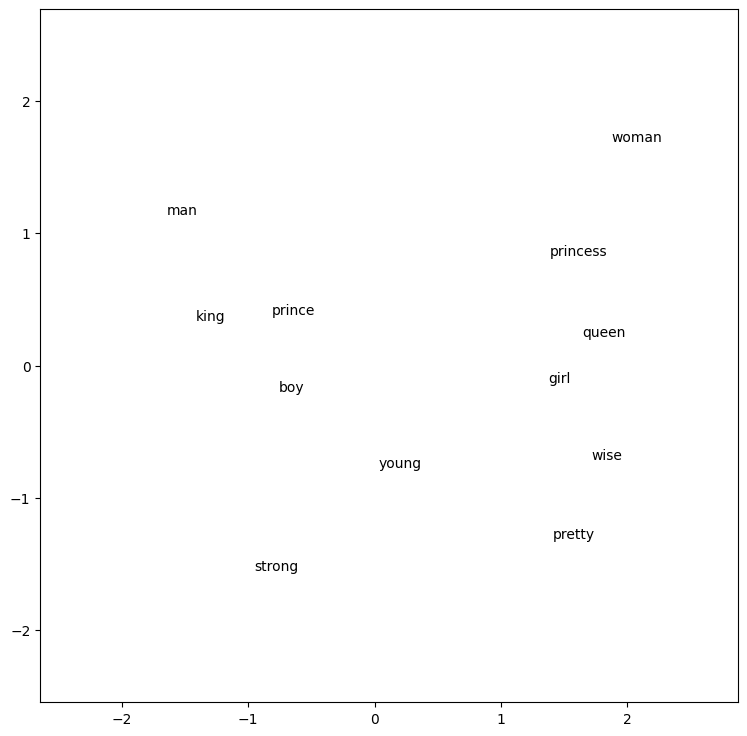

In [43]:
# 시각화
fig, ax = plt.subplots()

for word, x1, x2, in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
  ax.annotate(word, (x1, x2))

PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.rcParams["figure.figsize"] = (9,9)

plt.show()